In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import shutil
import time
import copy
from PIL import Image
import glob
import cv2
from google.colab import drive
from model import Model
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

In [11]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
# device = 'cpu'
device = 'cuda'
print('Current Device : {}'.format(device))

Current Device : cuda


In [13]:
# Code referred from: https://discuss.pytorch.org/t/saving-customized-model-architecture/21512/2
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)

    return model

In [14]:
model_path = './drive/MyDrive/models/model5/FaceMask_best.pth'
model= load_checkpoint(model_path)
class_names = ['Mask','Non Mask']

Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns a Numpy array

In [15]:
def process_image(image):
    tensor_transform = torchvision.transforms.ToTensor()
    normalize_transform = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                    std=[0.229, 0.224, 0.225])
    pil_image = image
    image_transforms = transforms.Compose([tensor_transform,
                                           normalize_transform])
    
    img = image_transforms(pil_image)
    return img

Predict the Class_Name from a given image

In [16]:
def classify_facemask(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    im = Image.fromarray(image)
    image = process_image(im)
    image.unsqueeze_(0)
    image.float()
    model.eval()
    output = model(image.to(device))
    _, predicted = torch.max(output, 1)
    classification1 = predicted.data[0]
    index = int(classification1)
    return class_names[index]

Test a single image here!

Text(0.5, 1.0, 'Mask')

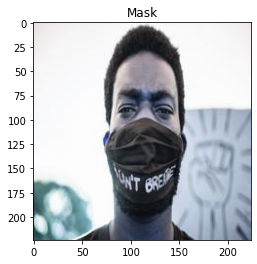

In [17]:
image = cv2.imread('./drive/MyDrive/New_Masks_Dataset/Test/Mask/1234.jpg')
label = classify_facemask(image)
plt.imshow(image)
plt.title(label)

In [18]:
class FaceMaskDataset(Dataset):
    def __init__(self, data_path, is_training):
        self.data_path = data_path
        self.train_path = os.path.join(data_path, 'Train')
        self.test_path = os.path.join(data_path, 'Test')
        self.is_training = is_training
        if self.is_training:
            self.target_path = self.train_path
        else:
            self.target_path = self.test_path

        self.classes = sorted(os.listdir(self.target_path))
        self.img_path_label = list()

        # 2 classes Mask and No Mask
        for c in self.classes:
            img_list = os.listdir(os.path.join(self.target_path, c))
            for fp in img_list:
                full_fp = os.path.join(self.target_path, c, fp)
                self.img_path_label.append((full_fp, c, self.classes.index(c)))
        

        # Add some tranforms for data augmentation.
        self.tensor_transform = torchvision.transforms.ToTensor()
        self.normalize_transform = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                    std=[0.229, 0.224, 0.225])

        self.random_flip = torchvision.transforms.RandomHorizontalFlip()
        self.resize = torchvision.transforms.Resize(size=224)
        self.random_rotation = torchvision.transforms.RandomRotation(degrees= 15)
        self.color_jitter = torchvision.transforms.ColorJitter()
        self.train_transform = torchvision.transforms.Compose([self.tensor_transform,  
                                                         self.resize,
                                                         self.random_flip, 
                                                         self.color_jitter,                                                    
                                                         self.random_rotation,
                                                         self.normalize_transform])
        self.validate_transform = torchvision.transforms.Compose([self.tensor_transform,
                                                                  self.normalize_transform])

    def __len__(self):
        return len(self.img_path_label)

    def __getitem__(self, idx):
        (fp, class_name, class_label) = self.img_path_label[idx]
        img = Image.open(fp)
        original_img = self.tensor_transform(img)

        if self.is_training:
            input = self.train_transform(img)
        else:
            input = self.validate_transform(img)
            
        sample = dict()
        sample['input'] = input
        sample['original_img'] = original_img
        sample['target'] = class_label
        sample['class_name'] = class_name

        return sample

Create dataset/dataloader for test

In [19]:
data_path= './drive/MyDrive/New_Masks_Dataset'
test_dataset = FaceMaskDataset(data_path, False)
test_dataloader = DataLoader(test_dataset, batch_size= 100, shuffle=True)

In [20]:
sample = next(iter(test_dataloader))

Text(0.5, 1.0, 'Non Mask')

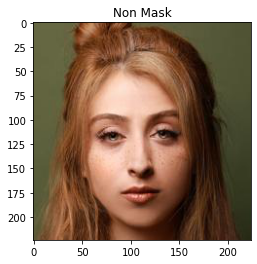

In [21]:
plot_idx = 2
plt.imshow(sample['original_img'][plot_idx].permute(1, 2, 0))
plt.title(sample['class_name'][plot_idx])

Test DataLoader

In [22]:
def test_model(model):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_dataloader:
            images, labels = data['input'].float().to(device), data['target'].long().to(device)  
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('correct: {:d}  total: {:d}'.format(correct, total))
    print('accuracy = {:f}'.format(correct / total))

In [23]:
#test the model
test_model(model)

correct: 101  total: 102
accuracy = 0.990196
